# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)

##  Project Capstone

### Reducing Electricity Costs in Romania: Predictive and Reinforcement Learning for Solar Battery Optimization

---

[README](../README.md) | [Part 1: Cleaning](01_Cleaning.ipynb) | [Part 2: EDA](02_EDA.ipynb) | [Part 3: Solar Energy Prediction Models](03_Model_Solar_Energy.ipynb) | [Part 4: Electricity Cost Prediction Models](04_Model_Electricity_Cost.ipynb) | [Part 5: Electricity Cost Prediction Using Time Series Models](05_Model_Electricity_Cost_ts.ipynb) | **Part 6: Solar Battery Optimization**

---

### Introduction
- A solar battery is a device that stores energy generated by solar panels for later use.
- **Charging** a solar battery involves storing excess energy generated by the solar panel. When a solar battery is charging, it is in a state of receiving energy and cannot simultaneously discharge or supply power to the system.
- **Discharging** occurs when the stored energy in the solar battery is used to supply power to the system. When a solar battery is discharging, it cannot simultaneously charge as it is in a state of providing energy.
- An optimization model using reinforcement learning will be designed to minimize electricity costs, considering the predicted solar power availability and electricity prices for each hour. The model will learn when to charge or discharge the solar battery based on the current state, optimizing the use of stored energy to ensure efficiency and cost-effectiveness.

### Assumption
- According to [Romania Total Energy Consumption](https://www.enerdata.net/estore/energy-market/romania/#:~:text=Romania%20Total%20Energy%20Consumption,again%20by%207.7%25%20in%202022.), the electricity consumption per capita is 2,300 kWh per year. Therefore, the average electricity usage per household of two people is approximately 13 kWh per day.
- According to [The Evolution of Romania's solar PV Market](https://rpia.ro/wp-content/uploads/2024/03/The-evolution-of-the-PV-market-in-Romania-in-2023.pdf?form=MG0AV3), as of 2023, the country has installed over 2.85 GW of solar capacity.
- According to [Romania's Rooftop Country Profile](https://caneurope.org/content/uploads/2024/04/Romania-Residental-Rooftop-Solar-Country-Profile.pdf?form=MG0AV3), households typically have solar panel sizes of 3 to 5 kW.

### Import

#### Essential Libraries

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
np.random.seed(42)

#### Import Data

In [3]:
df = pd.read_csv('../data/cleaned/electricity_romania.csv')       # Import
df['datetime'] = pd.to_datetime(df['datetime'])                   # Formatting `datetime`
df['month'] = df['datetime'].dt.month                             # Extract month
df['hour'] = df['datetime'].dt.hour                               # Extract hour
df['day'] = df['datetime'].dt.day                                 # Extract day

### Reinforcement Learning
- Reinforcement Learning (RL) is a branch of machine learning where an **agent** learns to make decisions by interacting with an **environment** to maximize cumulative **rewards**.
- The agent observes the state of environment, takes actions, and receives feedback in the form of rewards. Overtime, the agent learns a **policy**, a mapping from states to actions, that maximizes the expected cumulative rewards.
- One of the foundational methods in reinforcement learning is **Q-learning**.
- Q-learning is a model-free, off-policy algorithm where the agent learns the value of taking specific action in a specific state, known as the **Q-value**.
- The Q-values are stored in a table, called the **Q-table**, which gets updated iteratively using the **Bellman equation**:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha\left[r + \gamma \max_{a'}Q(s',a')-Q(s,a)\right]
$$

- Where:
  - $Q(s,a)$ is the Q-value of taking action $a$ in state $s$.
  - $\alpha$ is the learning rate.
  - $r$ is the immediate reward received after taking action $a$.
  - $\gamma$ is the discount factor, which determines the importance of future rewards.
  - $\max_{a'}Q(s',a')$ is the maximum Q-value for the next state $s'$.
- Through repeated interactions with the environment, the agent updates its Q-values and converges to an optimal policy, where it selects actions that lead to the highest cumulative rewards.

In [5]:
# Electricity Cost by Hour
env = pd.DataFrame(df['ckwh'].groupby(df['hour']).median())

### Q-learning for Solar Battery Optimization

#### Environment and Agent
- **Environment**
    - The electricity cost by hour is the median of the costs for each hour.
    - The solar energy collected by a household is calculated from the proportion of the median solar production (on a country scale) to the household scale.
    - The hourly load (hourly demand) is calculated based on the average usage per household, assumed to be 13 kWh per day. This demand is distributed according to three patterns: 1. Uniform, 2. Peak-hour usage, and 3. Non-peak hour usage.
      - Uniform: Energy usage is evenly distributed across all hours of the day.
      - Peak-hour usage: Energy usage is higher during peak hours, reflecting typical household consumption patterns.
      - Non-peak hour usage: Energy usage varies unpredictably and does not follow a consistent pattern.
- **Agent**
  - The agent interacts with the environment by making decisions to **Charge** or **Discharge** the solar battery.
  - The immediate reward for the agent is the electricity cost calculated based on its action.
    - dd

In [7]:
# Solar Energy Collected by Hour

# Daily Solar Energy Collected by Romania
daily_solar_romania = df['solar'].groupby(df['hour']).median().sum()

# Proportion to Household Scale (Solar Panel of 5 kW)
daily_solar_household = daily_solar_romania / 2850 * 5

print(f'Household Daily Solar Energy Collected: {daily_solar_household:.2f} kW')

Household Daily Solar Energy Collected: 5.80 kW


In [9]:
env['solar'] = df['solar'].groupby(df['hour']).median() / daily_solar_romania * daily_solar_household

In [41]:
# Uniform
env['load_uniform'] = 13 / 24
# Peak Hour
env['load_peak'] = env['ckwh'] * (13 / env['ckwh'].sum())
# Non Peak Hour
env['load_non_peak'] = (1 / env['ckwh']) * (13 / (1 / env['ckwh']).sum())

In [45]:
env.sum()

ckwh             179.335000
solar              5.799123
load_uniform      13.000000
load_peak         13.000000
load_non_peak     13.000000
dtype: float64

In [131]:
env.head()

,ckwh,solar,load_uniform,load_peak,load_non_peak
hour,,,,,
0,7.240,0.0,0.541667,0.524828,0.540989
1,6.890,0.0,0.541667,0.499456,0.568470
2,6.415,0.0,0.541667,0.465024,0.610563
3,6.110,0.0,0.541667,0.442914,0.641041
4,5.955,0.0,0.541667,0.431678,0.657726


#### Hyperparameter

In [135]:
# Initialize Q-Table as a dictionary
Q = {}

In [137]:
# Environment
ckwh = env['ckwh'].to_list()
solar = env['solar'].to_list()
ld = env['load_peak'].to_list()

In [251]:
# Hyperparameters
initial_reward = -3
alpha = 0.1                     # Learning rate
gamma = 0.99                    # Discount factor
min_epsilon = 0.01               # Minimum exploration rate
initial_epsilon = 1             # Initial exploration rate
decay_rate = 0.999              # Decay rate for epsilon
num_episodes = 10000            # Number of episodes

initial_battery = 3
max_battery = 100               # Maximum battery capacity



In [143]:
# ε-greedy policy function
# 0 = Charge
# 1 = Discharge

def act(state, Q, epsilon, default_value = initial_reward):
    if state not in Q:
        Q[state] = {0: default_value, 1: default_value}           # Check if state exists in Q, if not, add it with default values
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1])                           # Explore: choose a random action
    else:
        return max(Q[state], key=Q[state].get)                    # Exploit: choose best action based on Q-values

In [145]:
# Reward function
# The reward is equal to the electricity cost at each hour

def reward(state, battery_level, action):
    
    # Charge
    if action == 0:   
        rwd = -ckwh[state[0]] * ld[state[0]]
        next_battery_level = min(max_battery, battery_level + solar[state[0]])
        
    # Discharge    
    else:  
        if battery_level >= ld[state[0]]:
            rwd = 0
            next_battery_level = battery_level - ld[state[0]]
        else:
            rwd = -ckwh[state[0]] * (ld[state[0]] - battery_level)
            next_battery_level = 0
            
    next_state = (state[0] + 1, math.floor(next_battery_level), math.ceil(next_battery_level))
    return next_state, next_battery_level, rwd


In [147]:
# Update Q Table

def upd(state, action, next_state, rwd):
    # If it is not the end of the episode, update with the best next action
    if next_state[0] < 24:  
        
        if next_state not in Q:
            Q[next_state] = {0: initial_reward, 1: initial_reward}
            
        best_next_action = max(Q[next_state], key=Q[next_state].get)
        Q[state][action] += alpha * (rwd + gamma * Q[next_state][best_next_action] - Q[state][action])
   
    # Otherwise, use the immediate reward
    else:  
        Q[state][action] += alpha * (rwd - Q[state][action])

In [253]:
episode_rewards = []
actions_per_episode = []
threshold_counter = 0
threshold_limit = 5
threshold = 0.001

for episode in range(num_episodes):
    state = (0, initial_battery, initial_battery)
    battery_level = initial_battery
    epsilon = max(min_epsilon, initial_epsilon * (decay_rate ** episode))
    episode_reward = 0
    episode_actions = []

    Q_beg = sum([value for state_values in Q.values() for value in state_values.values()])
    
    while state[0] < 24:
        action = act(state, Q, epsilon)
        episode_actions.append((state[0], action))
        next_state, next_battery_level, rwd = reward(state, battery_level, action)
        upd(state, action, next_state, rwd)
        
        upd_Q = {s: v.copy() for s, v in Q.items()}
        state = next_state
        battery_level = next_battery_level
        episode_reward += rwd  # Accumulate the reward for the episode

        
    actions_per_episode.append(episode_actions)
    episode_rewards.append(episode_reward)
    Q_end = sum([value for state_values in Q.values() for value in state_values.values()])
    if abs(Q_beg - Q_end) < threshold:
        threshold_counter += 1
        print(episode)
    if threshold_counter > threshold_limit:
        break

398
618
1703
2567
2568
2569


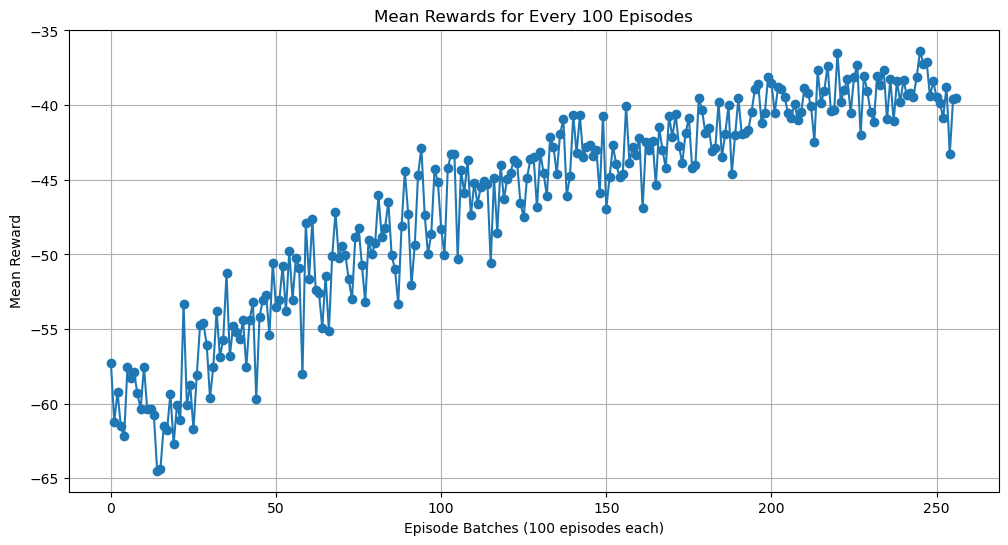

In [259]:
import numpy as np
import matplotlib.pyplot as plt

# Example data: Replace this with your actual episode_rewards data


# Calculate means for every 100 episodes
mean_rewards = [np.mean(episode_rewards[i:i+10]) for i in range(0, len(episode_rewards), 10)]

# Plot the mean rewards
plt.figure(figsize=(12, 6))
plt.plot(mean_rewards, marker='o')

# Adding labels and title
plt.xlabel('Episode Batches (100 episodes each)')
plt.ylabel('Mean Reward')
plt.title('Mean Rewards for Every 100 Episodes')
plt.grid(True)
plt.show()
